<a href="https://colab.research.google.com/github/FilipeSquire/Advanced-Analytics/blob/main/ClusteringExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xlrd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Importing the dataset
#In order for this code to work, you must use the data provided at the following link: 
#https://drive.google.com/file/d/1ZgnRMAovrHpBT3FQfs3URdpwz0nE4pLj/view?usp=sharing
dataset = pd.read_excel("INSERT PATH TO FILE")
dataset = dataset[dataset['CustomerID'].notna()] #Excluding null lines

pandas.core.frame.DataFrame

In [ ]:
#Taking a sample
ds2 = dataset.sample(10000, random_state = 42)

##Segmentin the customer via RFM
##It means: 
##Recency = how long ago the customer made his last purchase
##Frequency = how often the customer buys the product
#money = how much he pays

# Data Treatment

In [ ]:
#transform date-time into date
ds2['InvoiceDate'] = ds2['InvoiceDate'].dt.date

In [ ]:
#TotalSum column
ds2['TotalSum'] = ds2['Quantity'] * ds2['UnitPrice']

In [ ]:
#Recording recency
import datetime
snap_date = max(ds2.InvoiceDate) + datetime.timedelta(days=1)

In [ ]:
#Aggregating snap date by customer

customers = ds2.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snap_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

In [ ]:
#Renaming columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'},
                inplace=True)

In [ ]:
customers

# Stablishing standards

In [ ]:
## The data cannot be skewed and must have the save mean and variance ##

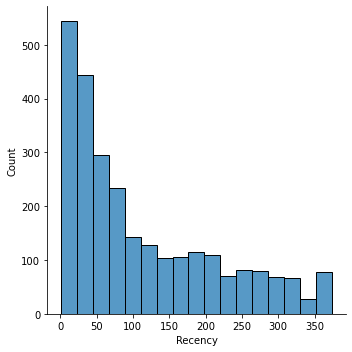

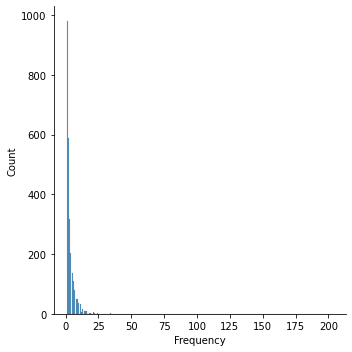

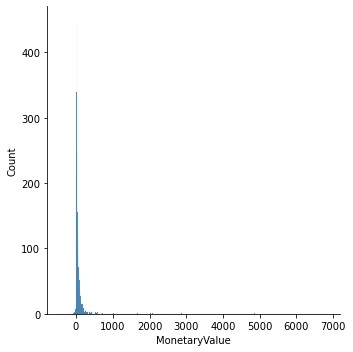

In [ ]:
import seaborn as sn

#The recency graph will show a huge concentration of data between 0-50 days
sn.displot(customers['Recency']) 

#The Frequency graph shows that theres a huge concentration of data close to 0 days, but the data
#needs to be treated in order to have a greater insight
sn.displot(customers['Frequency']) 

#No insights can be taken without a data cleasing
sn.displot(customers['MonetaryValue'])

In [ ]:
#Because of the distorted visualization in the graphs above, a easier way to actually get some insight
# we must transform the values
from scipy import stats
import matplotlib.pyplot as plt

#This function will use skew() which will treat the data by eliminating possible bias
def analyze_skewness(x):
    fig, ax = plt.subplots(2,2,figsize=(5,5))
    sn.distplot(customers[x], ax=ax[0,0])
    sn.distplot(np.log(customers[x]), ax=ax[0,1])
    sn.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sn.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

In [ ]:
analyze_skewness('Recency')
analyze_skewness('Frequency')

In [ ]:
#          Without  Log   Sqrt   Box-cox
# Recency  14.77    0.85  3.67   0.16
# Frequen  0.93    -0.72  0.32  -0.1
# the closer the value is to 0 less skew it will be
# therefore we will continue with the box values

In [ ]:
#We cant use negative values in our analysis in this point so we have to transform it
#in order to do that we will use cubic root transformation
#Down here we will have a comparison between the data with and without cubic root
fig, ax = plt.subplots(1,2,figsize=(10,3))
sn.distplot(customers['MonetaryValue'], ax=ax[0])
sn.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [ ]:
#From left to right, without and with cubic root respectively, we see that the skew value
#declined from 16 to 1

#Using the info discovered we must now apply these findings into our dataset

In [ ]:
dts2 = pd.DataFrame()
dts2['Recency'] = stats.boxcox(customers['Recency'])[0]
dts2['Frequency'] = stats.boxcox(customers['Frequency'])[0]
dts2['MonetaryValue'] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
dts2.tail()

In [ ]:
#Normalizing the data

from sklearn.preprocessing import StandardScaler

#Initialize object
scaler = StandardScaler()

#Fit and transform
scaler.fit(dts2)
dts2_normalized = scaler.transform(dts2)

#Assert that it has mean 0 and variance 1
print(dts2_normalized.mean(axis=0).round(2)) #[0. -0. 0]
print(dts2_normalized.std(axis=0).round(20)) #[1. 1. 1]

dts2_normalized

# MODELLING

In [ ]:
#K-MEANS MODEL

# >> Unsupervised Learning - it means that the algorithm will determ the classification by itself
# The K-means is a geometrical form to determine which clusters we'll have.
# We calculate the distance to each centroid, and each data belongs to a centroid doesnt matter
# the distance from the other. The calculations repeats itself until the next TOTAL DISTANCE doesnt
# have significant changes than before

# We will use the k-means model from scikit-learn library but to increase its performance we must use
# a hyperparameter and it must be determined by us. To determine which is the best, we will use the
# elbow method to decide.

In [ ]:
#What is an elbow method? The elbow method consists in picking the elbow of the curve as the number of clusters to be used.

In [ ]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(dts2_normalized)
    sse[k] = kmeans.inertia_ #SSE to closest cluster centroid

    plt.title('The Elbow Method')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sn.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()

In [ ]:
#SSE is y-axis and k is the x-axis. What does SSE means? What does K means?
#We take the parameter where the k-value will have a linear trend on the next consecutive k
#Therefore we will pick 3 for our model because the next k-value tend to have a linear trend.
#So we will have 3 clusters

In [ ]:
#Now we will fit our model with the code

model = KMeans(n_clusters=3, random_state=42)
model.fit(dts2_normalized)
model.labels_.shape

(2690,)

In [ ]:
#Inserting the clustering model into our RFM table

customers['Cluster'] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1)
customers

In [ ]:
#Now that we have implemented the plot we must take a look at how our clusters diverge
#In order to do that we must use the snake plot

In [ ]:
#Creating the dataframe
dts2_normalized = pd.DataFrame(dts2_normalized, columns=['Recency','Frequency','MonetaryValue'])
dts2_normalized['ID'] = customers.index
dts2_normalized['Cluster'] = model.labels_

#Melting the data
dts_nor_melt = pd.melt(dts2_normalized.reset_index(),
                      id_vars=['ID','Cluster'],
                      value_vars=['Frequency','MonetaryValue','Recency'],
                      var_name='Attribute',
                      value_name='Value')
dts_nor_melt.head()


#Visualizing the data
sn.lineplot('Attribute','Value',hue='Cluster',data=dts_nor_melt)

In [ ]:
#Looking at the graph, we see that the Cluster 2 buys with more frequency and has a higher value.
#Cluster 2 could be a Loyal Customer

#The cluster 0 is less frequent, has less value and but they buy recently.
#Therefore we could consider it as a New Customer that is usually less likely to buy expensive items
#on first hand, didnt have time to have a big frequency.

#The cluster 1 has all negative traits and they buy the product at the old time. It can be a
#churned customer